In [23]:
import pandas as pd
import re
from urllib.parse import unquote

In [24]:
df_url = pd.read_csv('input.csv')
df_url = df_url['url']

In [25]:
urls = df_url.to_list()

In [30]:
def extract_product_names(urls):
    # Regex for pages that are clearly not product-related
    not_products_pattern = re.compile(
        r'/.*(about|contact|blog|careers|news|info|faq|help|support|motivation|terms|privacy|recruit|recruitment|services|events|team|policy|overview|article|portfolio|corporate|shop|categories|login|signup|register|search|cart|checkout|legal|disclaimer|sitemap|client|testimonials|reviews|gallery|features|downloads|support|recommend|recommendation|customer-service|faq|press|forum|subscribe|promo|promotion|documentation).*', re.I)
    # Regex for common types of web page names that are not product specific
    common_web_pages = re.compile(r'(index\.html|index\.htm|index\.php|default\.aspx|default\.htm)$')
    # Updated identifier_pattern to include various non-descriptive numeric and short alphanumeric patterns
    identifier_pattern = re.compile(
    r'^(cid-\d+-\d+|[a-zA-Z0-9]{25,}|\d+-\d+|[A-Za-z]\s?\d+|\d+_\d+|(\d+\s+)+\d+|[A-Za-z]{1,2}\s\d+(\s\d+)*|' +
    r'[A-Za-z]{1,2}\s[A-Za-z]{1,2}\s\d+(\s\d+)*|\d{1,2}-\d{1,2}_\d+|[A-Za-z]{1,2}[-_ ][A-Za-z]{1,2}|' +
    r'(\d{1,2}[- ]){2}\d{1,2}|\d{1,3})$'
    )
       # Enhanced pattern to exclude common non-descriptive or irrelevant names
    non_descriptive_names = re.compile(
        r'^(www|https|http|index|home|main|default|none|user|users|portal|display|collections|node|update|updates|base|product|products|tag|tags|package|jobs|job|delivery|read|view|all|list|page|top|image|content|assets|public|api|misc|tmp|temp|\d+)$', re.I)
    non_english_keywords = re.compile(r'/.*(documentazione|dokumentation).*', re.I)  # Additional non-English terms

    url_to_product = {}  # Dictionary for URL to product name mappings

    for url in urls:
        product_urls = url.lower()
        if not_products_pattern.search(product_urls) or non_english_keywords.search(product_urls):
            continue
        
        segments = product_urls.strip().split('/')
        segments = [segment for segment in segments if segment and segment != 'https:']
        
        for segment in reversed(segments):
            product_name = unquote(segment)
            product_name = re.sub(r'[\?\.].*', '', product_name)  # Clean up parameters and extensions
            
            if common_web_pages.search(product_name) or identifier_pattern.match(product_name):
                continue
            
            product_name = product_name.replace('-', ' ').replace('_', ' ').title()  # Replace hyphens and underscores with spaces and capitalize
            
            if product_name and not non_descriptive_names.match(product_name) and len(product_name) > 2:
                url_to_product[url] = product_name  # Add to dictionary if it passes all filters
                break  # Stop if a valid product name is found

    return url_to_product

In [31]:
url_to_product = extract_product_names(urls)

In [32]:
url_to_product

{'https://capecodcandy.co/products/peach-gummies': 'Peach Gummies',
 'https://www.expertonlux.com/en/16-plafoniera?SubmitCurrency=1&id_currency=2': '16 Plafoniera',
 'https://agaplex.com/product/trappes-avec-cadre-type-ltr-c250-d400/': 'Trappes Avec Cadre Type Ltr C250 D400',
 'https://amitypacking.com/pork/ground-pork-retail.html': 'Ground Pork Retail',
 'https://www.doublepickups.com/xo-magnetic-condenser-mic-systems?itemId=vuw4620lsxphgoffc2rmn5opvdxn18-rbf3g': 'Xo Magnetic Condenser Mic Systems',
 'https://www.peugeot-brunei.com/electric-and-hybrid.html': 'Electric And Hybrid',
 'https://www.speedprint.pl/produkty/pokaz/winietki_boho': 'Winietki Boho',
 'https://www.ryokeninstinct.com/collections/ruku-bars/products/ruku-bar-bison': 'Ruku Bar Bison',
 'https://locozapoco.com/product-tag/100/': 'Product Tag',
 'https://arrozgelvez.com/gelvezconsienteapapa/': 'Gelvezconsienteapapa',
 'https://www.termotexsa.com/proyectos/galeras/': 'Galeras',
 'https://heritagesurfaces.com/color-story

In [33]:
product_df = pd.DataFrame(list(url_to_product.items()), columns=['URL', 'Product Name'])
product_df.to_csv('output.csv', index=False)

Taxonomy Data Preparation

In [9]:
# df_tax = pd.read_csv('taxonomy.csv')
# df_tax = df_tax[['Family', 'Family Name']]
# df_tax['Family'] = df_tax['Family'] // 10000
# df_tax.drop_duplicates(inplace=True, ignore_index=True)

In [10]:
# df_tax.to_csv('taxonomy_truncated.csv', index=False)

In [35]:
df_tax = pd.read_csv('taxonomy.csv')
df_tax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71502 entries, 0 to 71501
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Segment         71502 non-null  int64 
 1   Segment Name    71502 non-null  object
 2   Family          71502 non-null  int64 
 3   Family Name     71502 non-null  object
 4   Class           71502 non-null  int64 
 5   Class Name      71502 non-null  object
 6   Commodity       71502 non-null  int64 
 7   Commodity Name  71502 non-null  object
dtypes: int64(4), object(4)
memory usage: 4.4+ MB


In [46]:
# Initialize an empty dictionary to store your results
result_dict = {}

# Group the DataFrame by 'Family' which automatically groups by 'Family Name' due to their relationship
for _, group in df_tax.groupby('Family'):
    # Get the unique 'Family' ID (since all will be the same in the group, just take the first one)
    family_id = group['Family'].iloc[0]
    
    # Get the 'Family Name' (again, all are the same in the group, so take the first one)
    family_name = group['Family Name'].iloc[0]
    
    # Combine unique 'Class Name' and 'Commodity Name' from this group
    class_and_commodity_names = list(set(group['Class Name'].tolist() + group['Commodity Name'].tolist()))
    
    # Add to the dictionary
    result_dict[family_name] = (family_id, class_and_commodity_names)

# Now result_dict contains the mapping you wanted


In [49]:
print(result_dict['Paper materials'])

(14100000, ['Raw materials', 'Paper pulp'])


In [48]:
count = 0
for key in result_dict:
    if count < 2:
        print(key, ':', result_dict[key])
        count += 1
    else:
        break

Live animals : (10100000, ['Live freshwater silverside fish', 'Live foxes', 'Live drymarchon or indigo snake', 'Live sardine fish', 'Live philodryas snake', 'Live ispi fish', 'Live sponge', 'Live geese', 'Live bushmaster or lachesis snake', 'Live tilapia', 'Elephants', 'Live chilean recluse spider', 'Live epicrates or rainbow boa snake', 'Cats', 'Live clelia or mussurana snake', 'Live xenodon snake', 'Live mussels', 'Shellfish and aquatic invertebrates', 'Live coral or micrurus snake', 'Live aphid lion or chrysoperla externa', 'Alpaca', 'Mink', 'Live frigate tuna fish or melva fish', 'Live sole', 'Leeches', 'Live squid', 'Live chickens', 'Live paiche fish', 'Birds and fowl', 'Live oysters', 'Live shrimp', 'Live acarahuazu fish', 'Live llambina fish', 'Live clams', 'Live blochs catfish', 'Livestock', 'Live palometa fish or mylossoma aureum', 'Live abalone', 'Rabbits', 'Live maparate fish', 'Live mauri fish', 'Live carachi fish', 'Butterflies', 'Horses', 'Live salmon', 'Live guinea fowl'

Visualizing product names with clusters

In [17]:
import spacy
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [18]:
# Load spaCy's medium-sized English model
nlp = spacy.load('en_core_web_md')

In [19]:
def preprocess(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

In [20]:
# Transforming the dictionary to include both original and processed names
url_to_product_processed = {url: (product, preprocess(product)) for url, product in url_to_product.items()}

In [21]:
# Step 2: Generating Embeddings with spaCy
product_vectors = [nlp(text).vector for _, (_, text) in url_to_product_processed.items()]

KeyboardInterrupt: 

In [ ]:
# Step 3: Preparing Data for Clustering
# Convert list of vectors to a NumPy array
product_vectors = np.array(product_vectors)

In [ ]:
# Step 3: Applying the Elbow Method to determine the optimal number of clusters
def calculate_wcss(data):
    wcss = []
    for n in range(1, 11):  # Consider 1 to 10 clusters
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)  # Sum of squared distances of samples to their closest cluster center
    return wcss

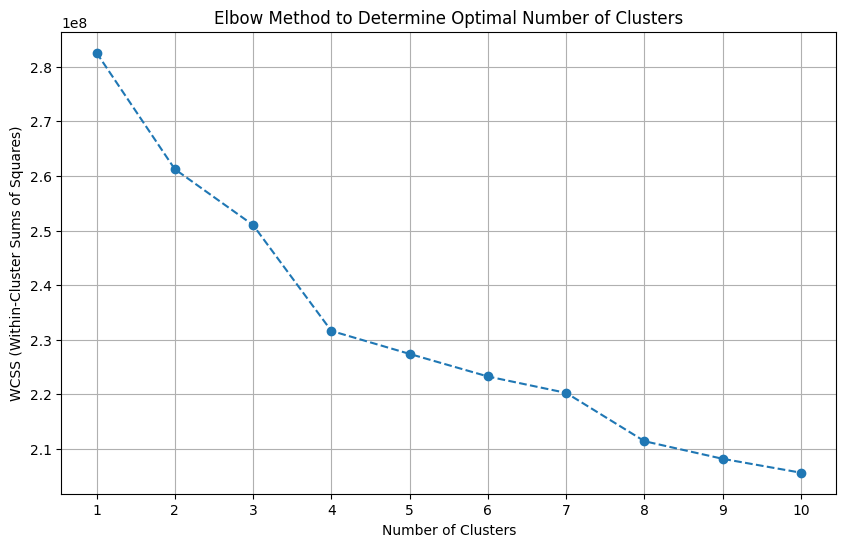

In [ ]:
wcss = calculate_wcss(product_vectors)

# Step 4: Plotting the Elbow Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method to Determine Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sums of Squares)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

In [ ]:
# Assuming `product_vectors` is already defined and contains the spaCy embeddings for the product names
optimal_num_clusters = 3  # As determined from the elbow method

In [ ]:
# Perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
kmeans.fit(product_vectors)

# The cluster labels for each data point
cluster_labels = kmeans.labels_

# If you want to associate the URLs with their respective clusters
url_to_cluster = {url: cluster_labels[idx] for idx, url in enumerate(url_to_product.keys())}


In [ ]:
import plotly.express as px
import plotly.offline as pyo


# Assuming `product_vectors` and `optimal_num_clusters` are already defined
# Perform PCA to reduce to 3 dimensions for visualization
pca = PCA(n_components=3)
reduced_vectors = pca.fit_transform(product_vectors)

# Perform K-Means clustering on the reduced data
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
kmeans.fit(reduced_vectors)

# Create a DataFrame for Plotly
df = pd.DataFrame(reduced_vectors, columns=['PCA1', 'PCA2', 'PCA3'])
df['Cluster'] = kmeans.labels_
df['Product'] = list(url_to_product.values())
df['URL'] = list(url_to_product.keys())

# Create an interactive 3D scatter plot with Plotly
fig = px.scatter_3d(df, x='PCA1', y='PCA2', z='PCA3', color='Cluster', hover_data=['Product', 'URL'],
                    title='3D PCA-based Cluster Visualization')

# Customize marker size
fig.update_traces(marker=dict(size=5))

# Use plotly.offline.plot to render the plot in the browser or save it as HTML
pyo.plot(fig, filename='3D_cluster_visualization.html')  # Opens in browser and saves HTML

'3D_cluster_visualization.html'